# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель проекта - обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Структура проекта**

1. Загрузка и подготовка данных
2. Обучение моделей 
3. Выводы

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Загрузка данных

In [1]:
# Проект выполнялся локально, поэтому устанавливались недостающие модули
!pip install nltk -q
!pip install pymystem3 -q
!pip install spacy -q
!python -m spacy download en_core_web_sm
!pip install wordcloud -q

In [2]:
# Подключаем модули
import spacy
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem

import torch
import transformers
from tqdm import notebook

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer

from tqdm.notebook import tqdm

from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler

In [3]:
# Зададим переменные RANDOM_STATE и TEST_SIZE
RANDOM_STATE = 42
TEST_SIZE = 0.5

In [4]:
# Загрузим данные
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('C:\\Users\pts12\\Downloads\\toxic_comments.csv', index_col=0)
    

In [5]:
df.head()

In [6]:
df.info()

Во входном датафрейме  з колонки и 159292 строки

## Анализ входных данных

In [7]:
# Проверка на пропуски
df.isna().sum()

In [8]:
# Проверка полных дубликатов
df.duplicated().sum()

In [9]:
# Проверка дубликатов в колонке 'text'
df['text'].duplicated().sum()

In [10]:
# Процент единичек в колонке 'toxic'
df['toxic'].mean() * 100

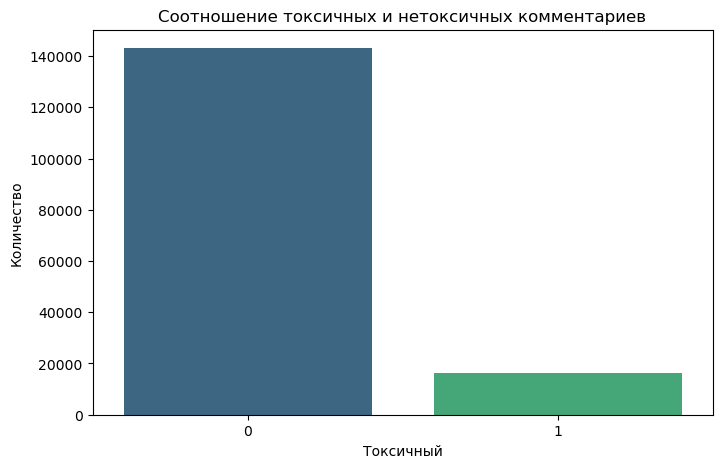

In [11]:
# выведем барплот для колонки 'toxic'
plt.figure(figsize=(8, 5))
sns.countplot(
data=df,
x='toxic',
palette='viridis'
)

plt.title('Соотношение токсичных и нетоксичных комментариев')
plt.xlabel('Токсичный')
plt.ylabel('Количество')
plt.show()

Дубликаты и пропуски в датафрейме отсутствуют. В целевом признаке 'toxic' наблюдается дисбаланс значений - количество единичек - 10 %, количество нулей - 90 %

In [12]:
# Количество слов в строке
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
# Количество символов в строке
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

In [13]:
df.head()

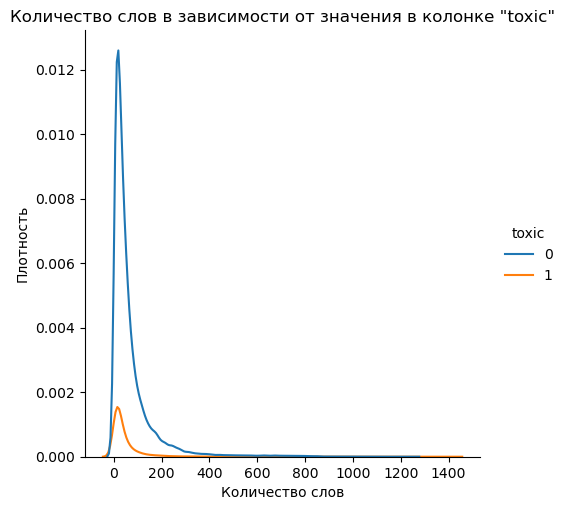

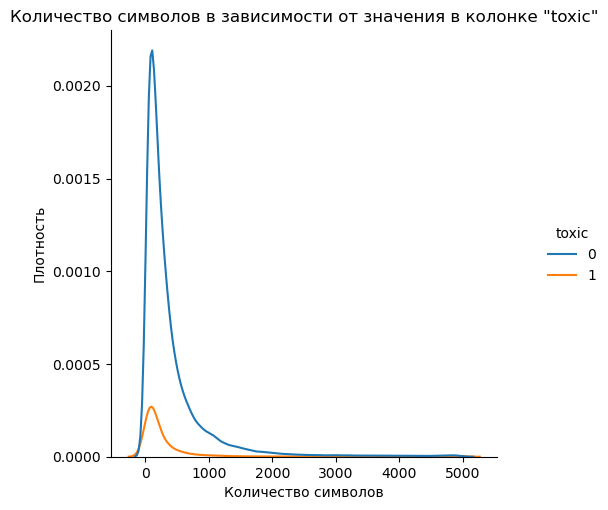

In [14]:
# Распределение количества символов и слов в зависимости от значения в колонке 'toxic'
sns.displot(data=df, x='word_count', hue='toxic',kind='kde')
plt.title(f'Количество слов в зависимости от значения в колонке "toxic"')
plt.xlabel('Количество слов')
plt.ylabel('Плотность')
plt.show()

sns.displot(data=df, x='char_count', hue='toxic', kind='kde')
plt.title(f'Количество символов в зависимости от значения в колонке "toxic"')
plt.xlabel('Количество символов')
plt.ylabel('Плотность')
plt.show()

    

In [15]:
df.query('toxic == 0')[['word_count', 'char_count']].describe().T

In [16]:
df.query('toxic == 1')[['word_count', 'char_count']].describe().T

По графикам и статистике видно, что токсичные комментарии короче нетоксичных по количеству символов и слов. Среднее количество символов - 404 для нетоксичных комментариев и 303 для токсичных. Среднее количество слов - 69 для нетоксичных комментариев и 53 для токсичных.

In [17]:
# Загруска стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

In [18]:
# Сэмплируем датафрейм для анализа с помощью облака слов
df_for_cloud = df.sample(n=10000, random_state=RANDOM_STATE)

In [19]:
# Функция для очистки текста (оставляем латинские буквы)
def clear_text(text):
    edited_text=re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(edited_text.split())

In [20]:
# Функция для лемматизации
nlp = spacy.load("en_core_web_sm")
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [21]:
df_for_cloud['text'] = df_for_cloud['text'].apply(clear_text).apply(lemmatize)

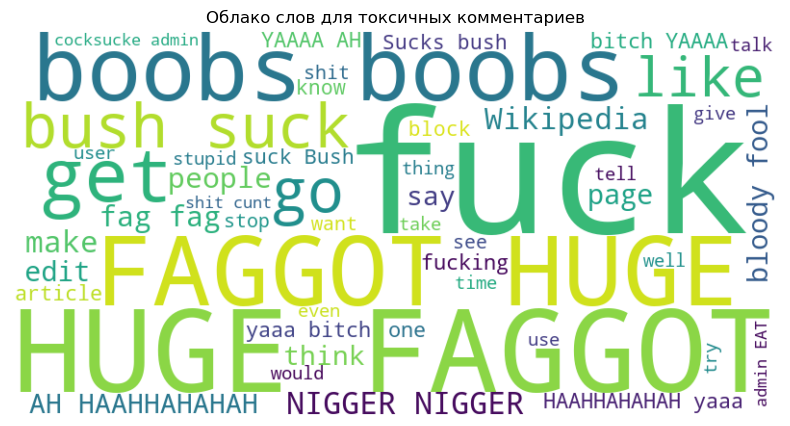

In [22]:
# Облако слов для токсичных комментариев
all_text = ' '.join(df_for_cloud.query('toxic == 1')['text'].astype(str))
wordcloud = WordCloud(
    width=800,          
    height=400,         
    background_color='white',  
    stopwords=stopwords,     
    max_words=50,      
    colormap='viridis'  
).generate(all_text)    

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Облако слов для токсичных комментариев')
plt.show()

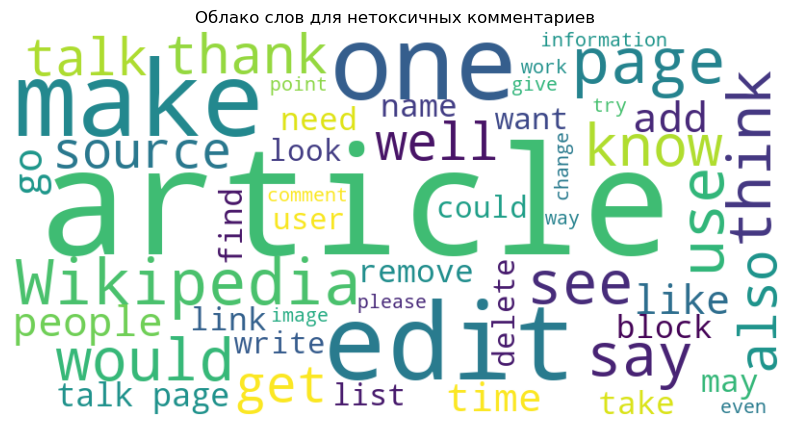

In [23]:
# Облако слов для нетоксичных комментариев
all_text = ' '.join(df_for_cloud.query('toxic == 0')['text'].astype(str))
wordcloud = WordCloud(
    width=800,          
    height=400,         
    background_color='white',  
    stopwords=stopwords,     
    max_words=50,      
    colormap='viridis'  
).generate(all_text)   

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для нетоксичных комментариев')
plt.show()

Из облаков слов видны явные различия в наборе слов между токсичными и нетоксичными комментариями.

## Подготовка данных и обучение модели без BERT 

In [24]:
# Сэмплируем датафрейм для экономии времении
df_sampled = df.sample(n=100000, random_state=RANDOM_STATE)

In [25]:
# Функция для очистки текста (оставляем латинские буквы)
def clear_text(text):
    edited_text=re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(edited_text.split())

In [26]:
# Функция для лемматизации
nlp = spacy.load("en_core_web_sm")
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [27]:
df_sampled['text'] = df_sampled['text'].apply(clear_text)

In [28]:
df_sampled.head(10)

In [29]:
%%time
tqdm.pandas()
df_sampled['lemm'] = df_sampled['text'].progress_apply(lemmatize)

In [30]:
df_sampled.head(10)

In [31]:
# Загруска стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

In [32]:
# Входной тектс и таргеты
features = df_sampled[['lemm', 'word_count']] 
targets = df_sampled['toxic']

In [33]:
# Разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [34]:
data_preprocessor = ColumnTransformer(
    [
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords)), 'lemm'),
     ('num', StandardScaler(), ['word_count'])   
    ]
)

In [35]:
# Инициализируем пайплайн
pipe= Pipeline([
    ('preproc', data_preprocessor),
    ('models', RandomForestClassifier(class_weight='balanced'))
]) 

In [36]:
# Создадим таблицу параметров (в моделях указываем class_weight='balanced')
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [RandomForestClassifier(class_weight='balanced')],
        'models__max_depth': [2, 5, 7],
        'models__n_estimators': [100, 200, 300],
        'preproc__tfidf__ngram_range': [(1, 1), (1, 2)],
    },
    {
        'models': [LogisticRegression(
            class_weight='balanced',
            random_state=RANDOM_STATE, 
        )],
        'models__C': range(1, 5),
        'preproc__tfidf__ngram_range': [(1, 1), (1, 2)],
    }    
    
]


In [37]:
grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

In [38]:
%%time
# Обучение моделей
grid.fit(X_train, y_train)

In [39]:
print('РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ БЕЗ BERT:\n\n')
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('F1-score лучшей модели по кроссвалидационной выборке:', (grid.best_score_))

In [40]:
# Предскажем целевой признак на тестовой выборке
y_test_pred = grid.predict(X_test)

In [41]:
print(f"F1-score на тестовой выборке (без BERT): {f1_score(y_test, y_test_pred ):.4f}")

Таким образом, лучший результат показала модель LogisticRegression(C=4, class_weight='balanced', random_state=42). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.76 и 0.77 

## Подготовка данных и обучение модели с BERT 

In [42]:
# Сэмплируем датафрейм для экономии времении
df_sampled2 = df.groupby('toxic', group_keys=False).apply(lambda x: x.sample(frac=0.01, random_state=RANDOM_STATE))

In [43]:
df_sampled2.head()

In [44]:
df_sampled2.shape

In [45]:
# Проверка пропорции таргета
df_sampled2['toxic'].mean()

In [46]:
# инициализируем токенизатор
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = df_sampled2['text'].apply(
    lambda x: tokenizer.encode(
        x, 
        add_special_tokens=True, 
        max_length=512,        # Ограничиваем длину
        truncation=True         # Включаем усечение
    )
)
max_len = 512
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [47]:
# Загружаем предобученную моделль и ее конфигурацию
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')

In [48]:
batch_size = 100
embeddings = []

# Переносим модель на GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    # Создаем батч
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    # переносим данные  GPU
    batch = batch.to(device)
    attention_mask_batch = attention_mask_batch.to(device)
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
   
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

In [49]:
# Объединим эмбеддинги для формирования входных признаков
features2 = np.concatenate(embeddings)

In [50]:
features2

In [51]:
# Создадим датафрейм с входными признаками
df_features2 = pd.DataFrame(features2)

In [52]:
df_features2.shape

In [53]:
# Добавим признак "word_count"
df_features2['word_count'] = df_sampled2.reset_index()['word_count']

In [54]:
df_features2.shape

In [55]:
df_features2.head()

In [56]:
df_features2.columns = df_features2.columns.astype(str)

In [57]:
# Задаем таргеты
targets2 = df_sampled2['toxic'].head(1500)

# Разделим датафрейм на тренировочную и тестовю выборки
X_train, X_test, y_train, y_test = train_test_split(df_features2, targets2, test_size=0.5, random_state=42)


In [58]:
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), ['word_count'])   
    ],
    remainder='passthrough'
)

In [59]:
# Инициализируем пайплайн
pipe2= Pipeline([
    ('preproc', data_preprocessor),
    ('models', RandomForestClassifier(class_weight='balanced')),
    
]) 

In [60]:
# Создадим таблицу параметров (в моделях указываем class_weight='balanced')
param_grid2 = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(class_weight='balanced')],
        'models__max_depth': range(2, 5, 7),
        'models__n_estimators': [100, 200, 300],
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=RANDOM_STATE, 
        )],
        'models__C': range(1, 5),
    }    
]

In [61]:
grid2 = GridSearchCV(
    pipe2, 
    param_grid2, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
)

In [62]:
%%time
# Обучение моделей
grid2.fit(X_train, y_train)

In [63]:
print('РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ С BERT:\n\n')
print('Лучшая модель и её параметры:\n\n', grid2.best_estimator_)
print ('F1-score лучшей модели по кроссвалидационной выборке:', (grid2.best_score_))

In [64]:
# Предскажем целевой признак на тестовой выборке
y_test_pred2 = grid2.predict(X_test)

In [65]:
print(f"F1-score на тестовой выборке (c BERT): {f1_score(y_test, y_test_pred2 ):.4f}")

Таким образом, лучший результат показала модель LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.87 и 0.92.

## Выводы

В данном проекте было выполнено обучение модели классификации с целью выявления токсичных комментариев.  
    
Во входном датафрейме содержится 159292 строки с текстом комментариев и целевой колонкой 'toxic'.  

Перед подготовкой данных была выполнена проверка на дубликаты и пропуски - выявлено не было. В целевом признаке "toxic" наблюдается дисбаланс значений - количество единичек - 10 %, количество нулей - 90 %.  

Подготовка данных к обучению моделей была выполнена в двух вариантах без BERT и с использованием BERT. В целях экономии времени в первом случае были выбраны в случайном порядке 100000 строк, во втором случае - 1500 строк.

**Обучение модели классификации без BERT**  

Лучший результат показала модель LogisticRegression(C=4, class_weight='balanced', random_state=42). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.76 и 0.77.  

**Обучение модели классификации с BERT**  
Лучший результат показала модель RandomForestClassifier(class_weight='balanced', max_depth=2). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.87 и 0.92.
